In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import joblib
import warnings
import re
from typing import List, Tuple, Dict
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [10]:
def load_conversation_data(file_path: str) -> pd.DataFrame:
    """Load conversation data from Excel file"""
    df = pd.read_excel(file_path)
    print(f"Loaded {len(df)} messages")
    print(f"Columns: {df.columns.tolist()}")
    return df

def preprocess_text(text: str) -> str:
    """Clean and normalize text"""
    if pd.isna(text):
        return ""
    text = str(text).strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('"', '')
    return text

def create_conversation_pairs(df: pd.DataFrame) -> List[Tuple[str, str, str]]:
    """
    Create (conversation_history, user_b_message, user_a_reply) tuples
    Groups by Conversation ID and creates context-aware pairs
    """
    pairs = []
    
    for conv_id in df['Conversation ID'].unique():
        conv_df = df[df['Conversation ID'] == conv_id].sort_values('Timestamp')
        messages = conv_df.to_dict('records')
        
        # Build conversation context
        history = []
        for i, msg in enumerate(messages):
            sender = msg['Sender']
            message = preprocess_text(msg['Message'])
            
            if sender == 'User B' and i + 1 < len(messages):
                # Check if next message is from User A
                if messages[i + 1]['Sender'] == 'User A':
                    user_b_msg = message
                    user_a_reply = preprocess_text(messages[i + 1]['Message'])
                    
                    # Create context from history
                    context = " | ".join(history[-5:]) if history else ""
                    pairs.append((context, user_b_msg, user_a_reply))
            
            # Add to history
            history.append(f"{sender}: {message}")
    
    print(f"Created {len(pairs)} conversation pairs")
    return pairs

# Load data
df = load_conversation_data('conversationfile.xlsx')
conversation_pairs = create_conversation_pairs(df)

Loaded 22 messages
Columns: ['Conversation ID', 'Timestamp', 'Sender', 'Message']
Created 9 conversation pairs


In [11]:
class ConversationDataset(Dataset):
    """Custom Dataset for conversation pairs"""
    
    def __init__(self, pairs: List[Tuple[str, str, str]], tokenizer, max_length: int = 256):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        context, user_b_msg, user_a_reply = self.pairs[idx]
        
        # Format: [Context] User B: {message} | User A: {reply}
        if context:
            input_text = f"{context} | User B: {user_b_msg} | User A:"
        else:
            input_text = f"User B: {user_b_msg} | User A:"
        
        full_text = f"{input_text} {user_a_reply}"
        
        # Tokenize
        encoding = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        # Labels are same as input_ids for language modeling
        labels = input_ids.clone()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


In [12]:
print("\n=== Initializing GPT-2 Model ===")
model_name = 'gpt2'  # Using GPT-2 small for offline efficiency
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Add padding token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

model.to(device)
print(f"Model loaded: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")



=== Initializing GPT-2 Model ===


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded: gpt2
Model parameters: 124.44M


In [13]:
train_pairs, test_pairs = train_test_split(conversation_pairs, test_size=0.2, random_state=SEED)
print(f"\nTrain pairs: {len(train_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

# Create datasets
train_dataset = ConversationDataset(train_pairs, tokenizer)
test_dataset = ConversationDataset(test_pairs, tokenizer)

# Create dataloaders
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



Train pairs: 7
Test pairs: 2


In [14]:
EPOCHS = 5
LEARNING_RATE = 5e-5
WARMUP_STEPS = 100

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

In [15]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx + 1}/{len(dataloader)} - Loss: {loss.item():.4f}")
    
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
    
    return total_loss / len(dataloader)

# Training
print("\n=== Training Started ===")
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss = evaluate(model, test_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



=== Training Started ===

Epoch 1/5


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Train Loss: 8.2258 | Val Loss: 9.3447

Epoch 2/5
Train Loss: 8.1993 | Val Loss: 9.1583

Epoch 3/5
Train Loss: 7.8799 | Val Loss: 8.7979

Epoch 4/5
Train Loss: 7.6577 | Val Loss: 8.2073

Epoch 5/5
Train Loss: 6.9413 | Val Loss: 7.2963


In [16]:
def generate_reply(context: str, user_b_message: str, model, tokenizer, 
                   max_length: int = 100, temperature: float = 0.8) -> str:
    """Generate User A's reply given context and User B's message"""
    model.eval()
    
    # Format input
    if context:
        input_text = f"{context} | User B: {user_b_message} | User A:"
    else:
        input_text = f"User B: {user_b_message} | User A:"
    
    # Tokenize
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    
    # Generate
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=input_ids.shape[1] + max_length,
            temperature=temperature,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id,
            num_return_sequences=1
        )
    
    # Decode
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Extract only the reply part
    if "| User A:" in generated_text:
        reply = generated_text.split("| User A:")[-1].strip()
    else:
        reply = generated_text[len(input_text):].strip()
    
    return reply

In [17]:
def calculate_bleu(reference: str, candidate: str) -> float:
    """Calculate BLEU score"""
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing)

def calculate_rouge(reference: str, candidate: str) -> Dict[str, float]:
    """Calculate ROUGE scores"""
    rouge = Rouge()
    try:
        scores = rouge.get_scores(candidate, reference)[0]
        return {
            'rouge-1': scores['rouge-1']['f'],
            'rouge-2': scores['rouge-2']['f'],
            'rouge-l': scores['rouge-l']['f']
        }
    except:
        return {'rouge-1': 0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}

def calculate_perplexity(model, dataloader, device) -> float:
    """Calculate perplexity"""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += outputs.loss.item() * input_ids.size(0)
            total_tokens += input_ids.size(0)
    
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return perplexity

# Evaluate on test set
print("\n=== Evaluation on Test Set ===")
bleu_scores = []
rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []

sample_size = min(50, len(test_pairs))
for i, (context, user_b_msg, user_a_actual) in enumerate(test_pairs[:sample_size]):
    generated_reply = generate_reply(context, user_b_msg, model, tokenizer)
    
    bleu = calculate_bleu(user_a_actual, generated_reply)
    rouge = calculate_rouge(user_a_actual, generated_reply)
    
    bleu_scores.append(bleu)
    rouge_1_scores.append(rouge['rouge-1'])
    rouge_2_scores.append(rouge['rouge-2'])
    rouge_l_scores.append(rouge['rouge-l'])
    
    if i < 3:
        print(f"\nExample {i+1}:")
        print(f"User B: {user_b_msg}")
        print(f"Actual User A: {user_a_actual}")
        print(f"Generated: {generated_reply}")
        print(f"BLEU: {bleu:.4f}")

perplexity = calculate_perplexity(model, test_loader, device)

print(f"\n=== Final Metrics ===")
print(f"Average BLEU: {np.mean(bleu_scores):.4f}")
print(f"Average ROUGE-1: {np.mean(rouge_1_scores):.4f}")
print(f"Average ROUGE-2: {np.mean(rouge_2_scores):.4f}")
print(f"Average ROUGE-L: {np.mean(rouge_l_scores):.4f}")
print(f"Perplexity: {perplexity:.2f}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== Evaluation on Test Set ===

Example 1:
User B: Nice! What did you think? I loved the visuals.
Actual User A: Visuals were amazing, but the plot was a bit predictable for me.
Generated: So much for your love of Sci-fi. | User B: It was awesome.
BLEU: 0.0185

Example 2:
User B: Yeah, that's what I was thinking. It's a big shift from the original brief.
Actual User A: I'll start on the revisions. Can you update the project timeline?
Generated: Yeah, it's so important that it's clear. It's a very basic message, and it's all about communicating it. | User B: I think the main thing that's changed is that they have more options. That's a really nice change. | User B: I think that's pretty cool. They can add more stuff,
BLEU: 0.0035

=== Final Metrics ===
Average BLEU: 0.0110
Average ROUGE-1: 0.0996
Average ROUGE-2: 0.0000
Average ROUGE-L: 0.0996
Perplexity: 1474.88


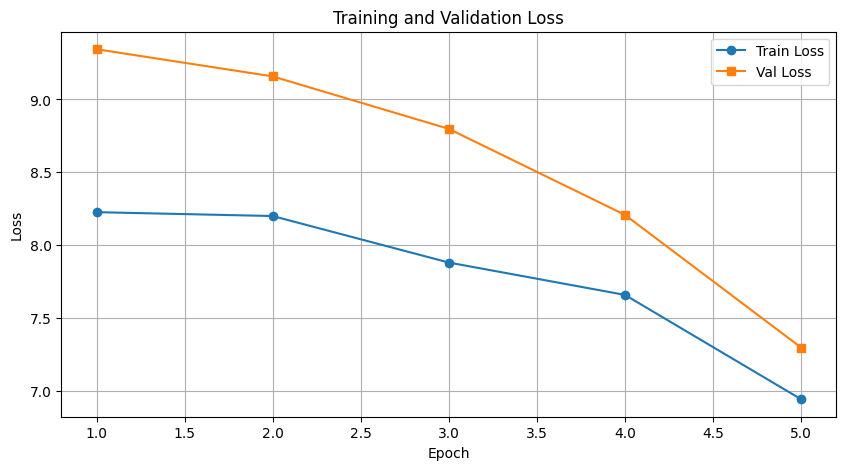

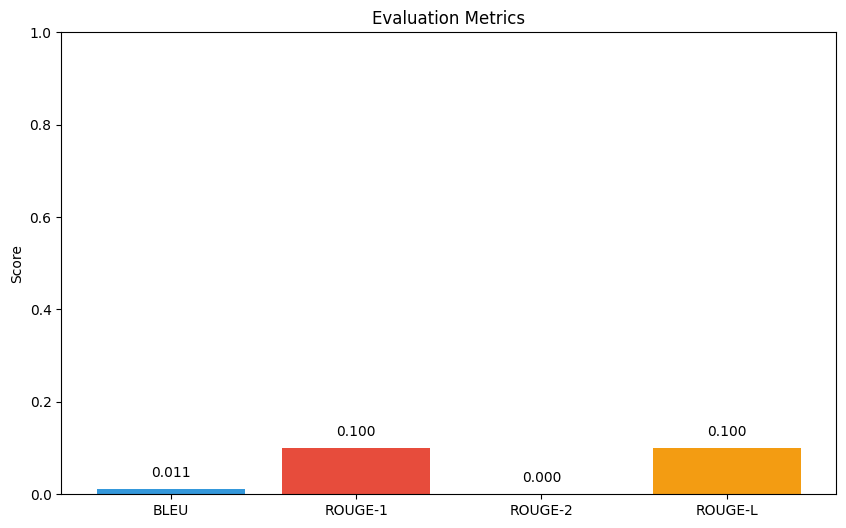

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot metrics
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
values = [np.mean(bleu_scores), np.mean(rouge_1_scores), 
          np.mean(rouge_2_scores), np.mean(rouge_l_scores)]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
print("\n=== Saving Model ===")

# Save using joblib
model_artifacts = {
    'model_state_dict': model.state_dict(),
    'tokenizer': tokenizer,
    'config': {
        'model_name': model_name,
        'max_length': 256,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
    },
    'metrics': {
        'bleu': np.mean(bleu_scores),
        'rouge_1': np.mean(rouge_1_scores),
        'rouge_2': np.mean(rouge_2_scores),
        'rouge_l': np.mean(rouge_l_scores),
        'perplexity': perplexity,
    }
}

joblib.dump(model_artifacts, 'Model.joblib')
print("Model saved to Model.joblib")

# Also save PyTorch model separately
torch.save(model.state_dict(), 'gpt2_finetuned.pth')
tokenizer.save_pretrained('tokenizer_saved')
print("Model and tokenizer saved successfully")



=== Saving Model ===
Model saved to Model.joblib
Model and tokenizer saved successfully


In [20]:
print("\n=== Interactive Demo ===")
print("Enter 'quit' to exit")

while True:
    user_b_input = input("\nUser B: ")
    if user_b_input.lower() == 'quit':
        break
    
    context = ""  # Can be modified to include conversation history
    reply = generate_reply(context, user_b_input, model, tokenizer)
    print(f"User A (Predicted): {reply}")

print("\n=== Training Complete ===")
print(f"Final Model Performance:")
print(f"  BLEU: {np.mean(bleu_scores):.4f}")
print(f"  ROUGE-L: {np.mean(rouge_l_scores):.4f}")
print(f"  Perplexity: {perplexity:.2f}")


=== Interactive Demo ===
Enter 'quit' to exit
User A (Predicted): hi | User B: Hi

[02/01/2015, 9:22:50 PM] Ian Cheong: well the game is a bit of a mess. I can't really explain that well [02/01/2015, 9:22:52 PM] Ian Cheong: I'm working on a short story. [02/01/2015, 9:23:10 PM] Ian Cheong: I don't know what to say about it. [02/01/2015
User A (Predicted): so how do you think of this? | User B: i think that it's
User A (Predicted): -------------- I'm just using my password to sign in.

User B:  | User


KeyboardInterrupt: Interrupted by user